In [2]:
import cv2 
import ast
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
from os import listdir
import pandas as pd
from scipy import interpolate
from scipy import ndimage
from tools import Tools

ImportError: No module named 'tools'

# Test different methods for filtering and filling in missing values:
* Filling in missing values does not work properly
* Tried different filters (Kalmann, Gaussian, Cubic and linear interpolation) to fill in the values and smoothen the curve
* Problem: Sometimes the outliers are actually the right values
* Used LSTM to learn coordinate trajectories to fill in missing values, works but not plotted yet

In [12]:
data = np.load("/Users/ninawiedemann/Desktop/UNI/Praktikum/numpy arrays/unpro_all_coord.npy")[:,:,:12,:]

In [1]:
joints=["Right shoulder", "Left shoulder", "Right elbow", "Right wrist","Left elbow", "Left wrist",
        "Right hip", "Right knee", "Right ankle", "Left hip", "Left knee", "Left ankle", "Neck ",
        "Right eye", "Right ear","Left eye", "Left ear"]
#print(data[540, 92:95])
def normalize(data):
    M,N, nr_joints,_ = data.shape
    means = np.mean(data, axis = 1)
    std = np.std(data, axis = 1)
    res = np.asarray([(data[:,i]-means)/(std+0.000001) for i in range(len(data[0]))])
    data_new = np.swapaxes(res, 0,1)
    return data_new, means, std

def renormalize(data, means, std, one_pitch=None):
    if one_pitch is None:
        res = np.asarray([data[:,i]*std+means for i in range(len(data[0]))])
        #print(res.shape)
        data_new = np.swapaxes(res, 0,1)
    else:
        print(data.shape)
        data_new = np.asarray([data[i]*std[one_pitch]+means[one_pitch] for i in range(len(data))])
    return data_new

norm, means, std = normalize(data)
possible_interpo = ["linear", "nearest", "zero", "slinear", "quadratic", "cubic’ where ‘zero", "cubic"]
inter = 6
DATA_EX =  803 #795 96, 773 96, 796 94, 803 98
FRAME = 98
RANGE = 10
START = FRAME-RANGE
END = FRAME+RANGE
START_JOINT = 0
example = np.array(norm[DATA_EX])
linear = example.copy()
cubic = example.copy()
smooth = example.copy()
kal = example.copy()
ml = example.copy()
not_zer = np.where(data[DATA_EX, START:END, 1, 0]!=0)[0]
N,j, co = example.shape
smo2 = np.zeros((N*2, j, co))
indices = np.arange(0, END-START, 1)
ind_twice = np.arange(0, (END-START)-0.5, 0.5)

# ML FILL IN
"""
sequ = np.delete(data, FRAME, axis=1)[:, FRAME-10:FRAME+9, :12, :]
sequ = Tools.normalize(sequ)[DATA_EX]
sequ_around = np.reshape(sequ, (1, len(sequ), 24))
print(sequ_around.shape)
ml[FRAME] = np.reshape(get_ML_coord(sequ_around)[0], (12,2))
"""

#print(sequ_around)
plot = ["gaussian_filter", "kalmann", "linear"]

ml = np.load("/Users/ninawiedemann/Desktop/UNI/Praktikum/numpy arrays/ml_predict_all.npy")[DATA_EX]
# print(ml[START:END, 0, 0])


for i in range(12):
    for j in range(2):
        #print(not_zer, example[not_zer+START, i,j], indices)
        #print(not_zer*2, example[not_zer+START, i,j], ind_twice)
        f = interpolate.interp1d(not_zer, example[not_zer+START, i,j], kind=possible_interpo[inter])
        cubic[START:END, i, j] = np.round(f(indices), 1)
        new = np.interp(indices, not_zer, example[not_zer+START,i,j])
        new2= interpolate.interp1d(not_zer, example[not_zer+START, i,j], kind=possible_interpo[inter])
        linear[START:END, i, j] =  new
        smooth[START:END, i, j] = ndimage.filters.gaussian_filter1d(new, sigma = 1)
        #smo2[(START-RANGE):(END+RANGE)-1, i, j]= np.round(f(ind_twice),1)
        # kal[START:END, i, j] = kalmann(new)[1]
    fig = plt.figure(figsize = (20,10))
    ax = fig.add_subplot(111)
    dic = {"linear": [linear[START:END, i, 0], linear[START:END, i, 1]],
           "kalmann": [kal[START:END, i, 0], kal[START:END, i, 1]],
          "cubic": [cubic[START:END, i, 0], cubic[START:END, i, 1]],
          "gaussian_filter": [smooth[START:END, i, 0], smooth[START:END, i, 1]],
          "twice_values": [smo2[START-RANGE:END+RANGE-1, i, 0], smo2[START-RANGE:END+RANGE-1, i, 1]],
          "ml": [ml[START:END, i, 0], ml[START:END, i, 1]]}
    for kind in plot:
        meX = dic[kind][0]
        meY = dic[kind][1]
        plt.plot(meX, meY, label= kind)
        for k in range(START,END):
            if k==FRAME:
                ax.annotate(str(k), (meX[k-START], meY[k-START]), size=20)
            else:
                ax.annotate(str(k), (meX[k-START], meY[k-START]))
    plt.title(joints[i+START_JOINT])
    plt.grid()
    plt.legend()
    plt.show()

NameError: name 'data' is not defined

### Get suitable video from harddrive and cf file

In [24]:
from data_preprocess import Preprocessor
prepro = Preprocessor("/Users/ninawiedemann/Desktop/UNI/Praktikum/csvs/unprocessed_data.csv")
prepro.remove_small_classes(50)
print(prepro.cf.shape)
print(prepro.cf.iloc[DATA_EX]["Game"])
release = prepro.cf.iloc[DATA_EX]["pitch_frame_index"]
print(release)

path = "/Volumes/Nina Backup/videos/atl/"
#path_input_dat = "/Volumes/Nina Backup/videos/atl/2017-04-14/center field/490251-0f308987-60b4-480c-89b7-60421ab39106.mp4.dat"
dates = "2017-07-16" #, "2017-04-18", "2017-05-02", "2017-05-06"] # , "2017-05-19", "2017-05-23", "2017-06-06", "2017-06-10", "2017-06-18", "2017-06-22", "2017-07-04", "2017-07-16",
# "2017-04-15", "2017-04-19", "2017-05-03", "2017-05-07", "2017-05-20", "2017-05-24", "2017-06-07", "2017-06-11", "2017-06-19", "2017-06-23", "2017-07-05", "2017-07-17"]
# only first two rows von den im cluster angezeigten
# output_folder=args.output_dir
file = prepro.cf.iloc[DATA_EX]["Game"] + ".mp4" #491465-1a697776-fcf9-4a5e-817e-c38f975a6ce8.mp4"

/Users/ninawiedemann/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (254,255,256,257,258,259,260,290) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


csv eingelesen with length  13150
Only Pitcher rows
[['Changeup' 491]
 ['Curveball' 627]
 ['Eephus' 1]
 ['Fastball (2-seam)' 1341]
 ['Fastball (4-seam)' 2075]
 ['Fastball (Cut)' 287]
 ['Fastball (Split-finger)' 49]
 ['Knuckle curve' 73]
 ['Knuckleball' 350]
 ['Sinker' 265]
 ['Slider' 913]
 ['Unknown Pitch Type' 103]]
Removed because not enought class members:  ['Eephus' 'Fastball (Split-finger)'] Unknown Pitch Type
(6422, 445)
491465-953f27f2-4ac1-4f93-9cb0-1bbf0c721bc5
91.0


### Plot on video

In [25]:
output = []
input_dir = path+dates+"/center field/"
video_capture = cv2.VideoCapture(input_dir+file)
game_id = file[:-4]

for i in open(input_dir+file+".dat").readlines():
    datContent=ast.literal_eval(i)

bottom_p=datContent['Pitcher']['bottom']
left_p=datContent['Pitcher']['left']
right_p=datContent['Pitcher']['right']
top_p=datContent['Pitcher']['top']
bottom_b=datContent['Batter']['bottom']
left_b=datContent['Batter']['left']
right_b=datContent['Batter']['right']
top_b=datContent['Batter']['top']
#center_dic['Pitcher']=np.array([abs(top_p-bottom_p)/2., abs(left_p-right_p)/2.])
#center_dic['Batter']=np.array([abs(top_b-bottom_b)/2., abs(left_b-right_b)/2.])
frames = np.zeros((167, 221, 290, 3))
i = 0
while True:
    ret, frame = video_capture.read()
    if frame is None:
        break
    pitcher = frame[top_p:bottom_p, left_p:right_p]
    # batter = frame[top_b:bottom_b, left_b:right_b]
    frames[i]= pitcher
    i+=1

output.append(frames)

(167, 12, 2)
(167, 12, 2)
(167, 12, 2)
(167, 221, 290, 3)
91.0
88


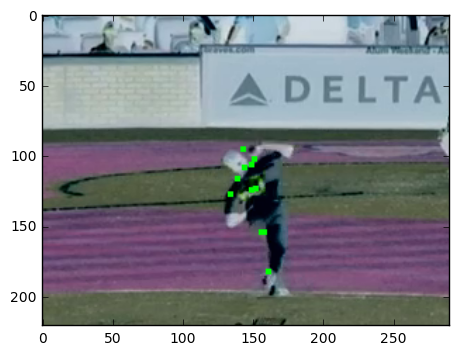

89


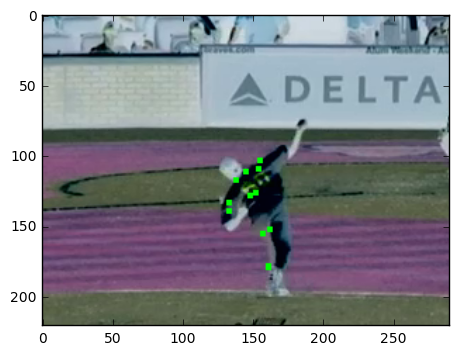

90


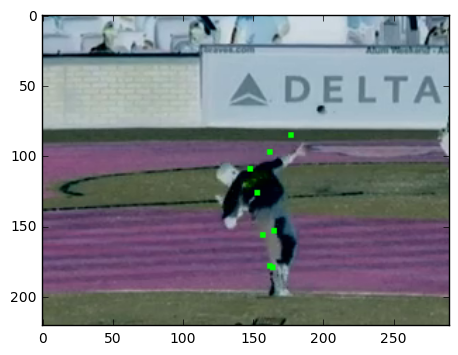

91
BALL RELEASE FRAME


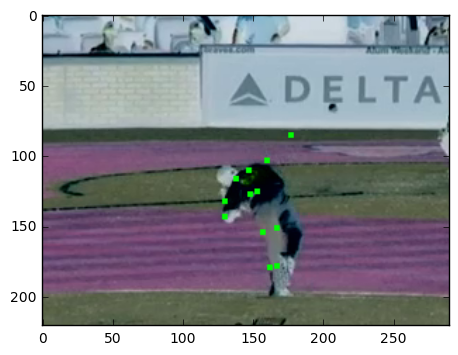

92


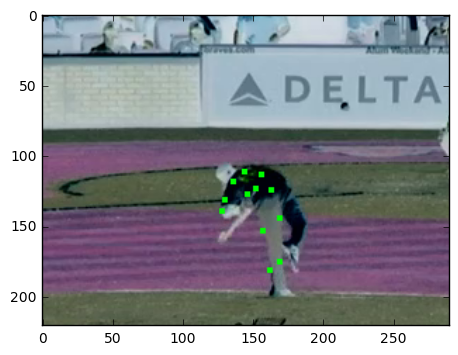

93


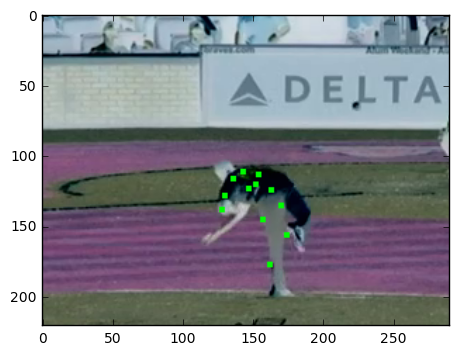

94


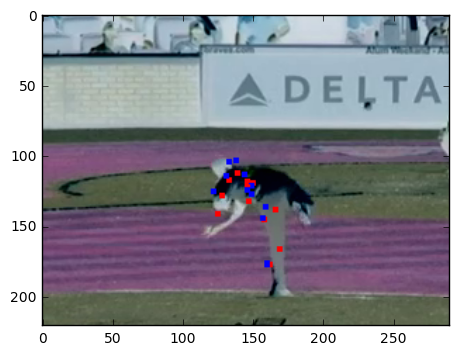

95


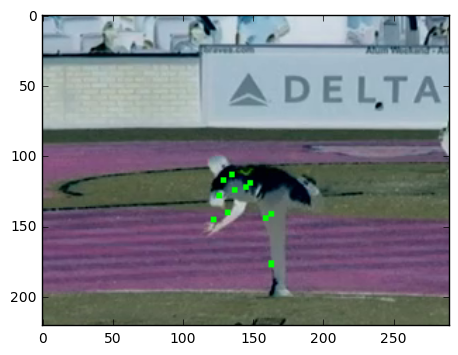

96


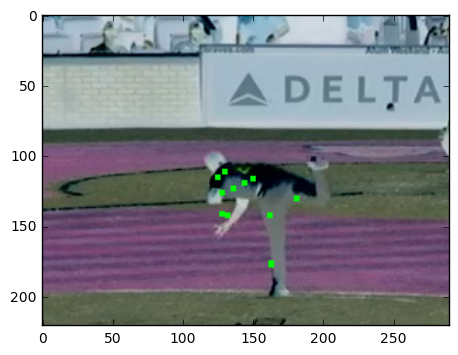

97


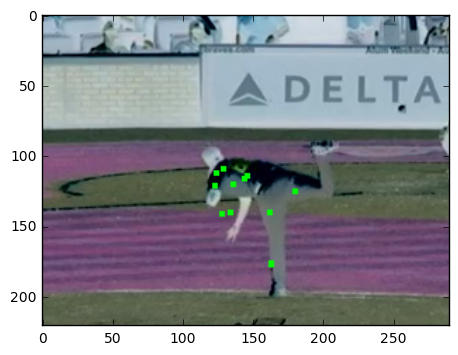

98


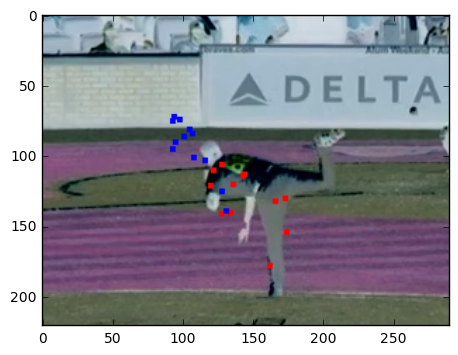

99


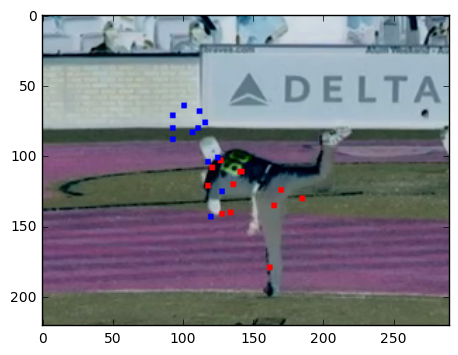

100


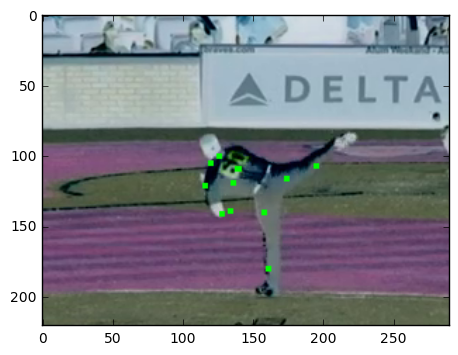

101


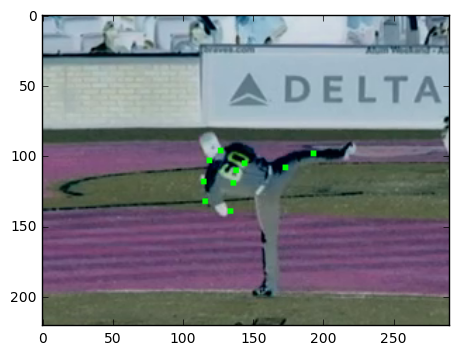

102


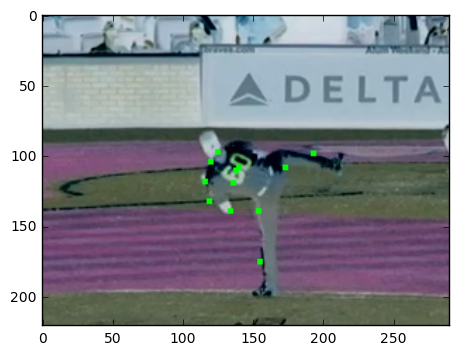

103


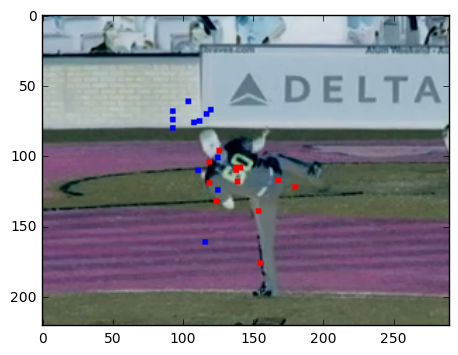

104


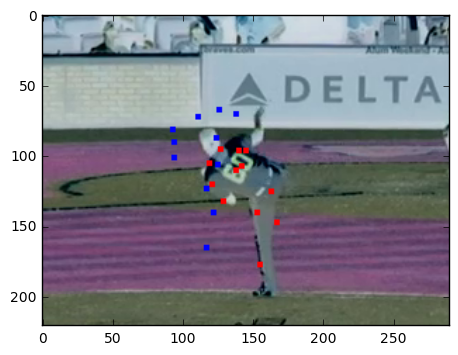

105


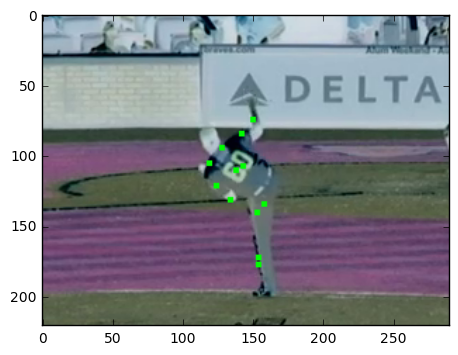

106


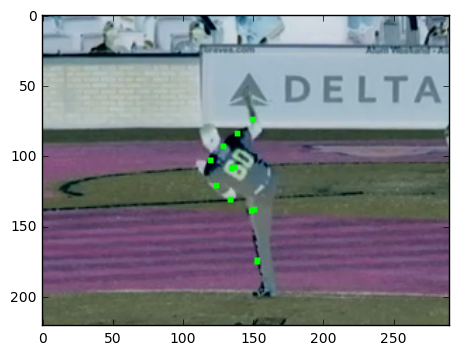

107


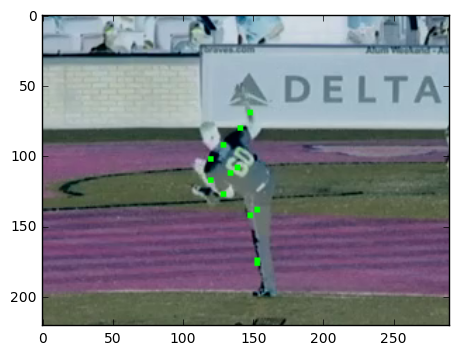

In [26]:
""" RED POINTS ARE SMOOTHED, GREEN UNPROCESSED"""

linear = renormalize(linear, means, std, one_pitch = DATA_EX)
ml = renormalize(ml, means, std, one_pitch = DATA_EX)
example = renormalize(example, means, std, one_pitch = DATA_EX)

vid = output[0]
print(vid.shape)
print(release)
for i in range(START, END):
    print(i)
    if i==release:
        print("BALL RELEASE FRAME")
    for j in range(12):
        x = linear[i, j, 0]
        y = linear[i,j,1]
        vid[i,int(x)-2:int(x)+2, int(y)-2:int(y)+2]=[1,0,0] # red
        x = ml[i, j, 0]
        y = ml[i,j,1]
        vid[i,int(x)-2:int(x)+2, int(y)-2:int(y)+2]=[0,0,1] # blue
        x = example[i, j, 0]
        y = example[i,j,1]
        vid[i,int(x)-2:int(x)+2, int(y)-2:int(y)+2]=[0,1,0] # green : normal
    plt.imshow(vid[i])
    plt.show()

## Kalmann filtering

In [ ]:
bsp_sequ_x = linear[START:END, 3, 0]
bsp_sequ_y = linear[START:END, 3, 1]
print(len(bsp_sequ_x))

"""plt.figure()
plt.plot(bsp_sequ_x, bsp_sequ_y, label = "before_filtering")
plt.show()"""

plt.rcParams['figure.figsize'] = (10, 8)

def kalmann(sequence):
    # intial parameters
    n_iter = len(sequence)
    sz = (n_iter,) # size of array
    #x = -0.37727 # truth value (typo in example at top of p. 13 calls this z)
    z = sequence #np.random.normal(x,0.1,size=sz) # observations (normal about x, sigma=0.1)

    Q = 1e-5 # process variance

    # allocate space for arrays
    xhat=np.zeros(sz)      # a posteri estimate of x
    P=np.zeros(sz)         # a posteri error estimate
    xhatminus=np.zeros(sz) # a priori estimate of x
    Pminus=np.zeros(sz)    # a priori error estimate
    K=np.zeros(sz)         # gain or blending factor

    R = 0.1**4 # estimate of measurement variance, change to see effect

    # intial guesses
    xhat[0] = sequence[0]
    P[0] = 1.0

    for k in range(1,n_iter):
        # time update
        xhatminus[k] = xhat[k-1]
        Pminus[k] = P[k-1]+Q

        # measurement update
        K[k] = Pminus[k]/( Pminus[k]+R )
        xhat[k] = xhatminus[k]+K[k]*(z[k]-xhatminus[k])
        P[k] = (1-K[k])*Pminus[k]
    return sequence, xhat

zx, xhatnew = kalmann(bsp_sequ_x)
zy, yhat = kalmann(bsp_sequ_y)

plt.figure()
plt.plot(zx,'k+',label='noisy measurements')
plt.plot(xhatnew,'b-',label='a posteri estimate')
# plt.axhline(x,color='g',label='truth value')
plt.legend()
plt.title('Estimate vs. iteration step', fontweight='bold')
plt.xlabel('Iteration')
plt.ylabel('x_coord')
plt.show()

plt.figure()
plt.plot(zy,'k+',label='noisy measurements')
plt.plot(yhat,'b-',label='a posteri estimate')
# plt.axhline(x,color='g',label='truth value')
plt.legend()
plt.title('Estimate vs. iteration step', fontweight='bold')
plt.xlabel('Iteration')
plt.ylabel('y_coord')
plt.show()

plt.figure()
plt.plot(bsp_sequ_x, bsp_sequ_y,'k-',label='noisy measurements')
plt.plot(xhatnew, yhat, 'b-',label='a posteri estimate')
# plt.axhline(x,color='g',label='truth value')
plt.legend()
plt.title('Estimate vs. iteration step', fontweight='bold')
plt.xlabel('x')
plt.ylabel('y')
plt.show()